# Questrade Portfolio Manager

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from qtrade import Questrade as qt
#from questrade_api import Questrade

## Authentication to Questrade API

In [2]:
try:
    qtrade = qt(token_yaml='access_token.yml')
except:
    code = open("access_code.txt", "r").read()
    qtrade = qt(access_code=code)

In [3]:
try:
    acctId = qtrade.get_account_id()
except:
    qtrade.refresh_access_token(from_yaml=True)
    acctId = qtrade.get_account_id()
acctId

['51802566']

In [4]:
# Define Request Call to Get Balance from Questrade API (Not Implemented in qtrade)
token = qtrade.access_token
token_type = token['token_type']
access_token = token['access_token']
url = token['api_server'] + '/v1/accounts/' + acctId[0] + '/balances'
bal = requests.get(url,
                   headers={'Authorization': f'{token_type} {access_token}'})
balance = bal.json()
balance

{'perCurrencyBalances': [{'currency': 'CAD',
   'cash': 31785.3365,
   'marketValue': 0,
   'totalEquity': 31785.3365,
   'buyingPower': 31785.3365,
   'maintenanceExcess': 31785.3365,
   'isRealTime': True},
  {'currency': 'USD',
   'cash': 23155.1215,
   'marketValue': 8247,
   'totalEquity': 31402.1215,
   'buyingPower': 23155.1215,
   'maintenanceExcess': 23155.1215,
   'isRealTime': True}],
 'combinedBalances': [{'currency': 'CAD',
   'cash': 61030.254954,
   'marketValue': 10415.961,
   'totalEquity': 71446.215955,
   'buyingPower': 61030.254954,
   'maintenanceExcess': 61030.254954,
   'isRealTime': True},
  {'currency': 'USD',
   'cash': 48321.658713,
   'marketValue': 8247,
   'totalEquity': 56568.658713,
   'buyingPower': 48321.658713,
   'maintenanceExcess': 48321.658713,
   'isRealTime': True}],
 'sodPerCurrencyBalances': [{'currency': 'CAD',
   'cash': 31785.3365,
   'marketValue': 0,
   'totalEquity': 31785.3365,
   'buyingPower': 31785.3365,
   'maintenanceExcess': 31785

## Position Summary

In [5]:
# qtrade.ticker_information('MO')

In [6]:
position_data = {
    'Symbol': [],
    'Description': [],
    'Currency': [],
    'Quantities': [],
    'Market Value': [],
    'Gain/Loss (%)': []
}
total_costs = 0
total_market_value = 0
for account in acctId:
    positions = qtrade.get_account_positions(account)
    for position in positions:
        symbol = position['symbol']
        description = qtrade.ticker_information(symbol)['description']
        qty = position['openQuantity']
        cmv = position['currentMarketValue']
        currency = qtrade.ticker_information(symbol)['currency']
        cost = position['totalCost']
        change = round(100 * (cmv - cost) / cost, 2)

        total_market_value = total_market_value + cmv
        total_costs = total_costs + cost
        position_data['Symbol'].append(symbol)
        position_data['Description'].append(description)
        position_data['Currency'].append(currency)
        position_data['Quantities'].append(qty)
        position_data['Market Value'].append(cmv)
        position_data['Gain/Loss (%)'].append(change)

In [7]:
portfolio = pd.DataFrame(position_data)
portfolio.set_index('Symbol', inplace=True)
portfolio

,Description,Currency,Quantities,Market Value,Gain/Loss (%)
Symbol,,,,,
O,REALTY INCOME CORP,USD,75,4762.50,3.76
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARK...,USD,3,620.07,5.63
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,638.26,-0.17
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1119.72,-8.23
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/0...,USD,4,541.80,-10.69
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND...,USD,5,564.65,-4.81


In [8]:
total_equity = balance['perCurrencyBalances'][1]['totalEquity']
portfolio['%Portfolio'] = [
    round(100 * (x / total_equity), 2) for x in portfolio['Market Value']
]

In [9]:
portfolio

,Description,Currency,Quantities,Market Value,Gain/Loss (%),%Portfolio
Symbol,,,,,,
O,REALTY INCOME CORP,USD,75,4762.50,3.76,15.17
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARK...,USD,3,620.07,5.63,1.97
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,638.26,-0.17,2.03
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1119.72,-8.23,3.57
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/0...,USD,4,541.80,-10.69,1.73
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND...,USD,5,564.65,-4.81,1.80


<AxesSubplot:title={'center':'Portfolio Breakdown'}, ylabel='%Portfolio'>

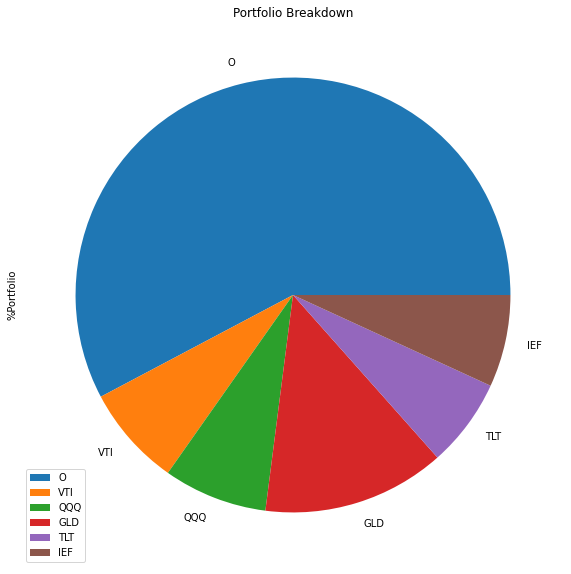

In [10]:
portfolio['%Portfolio'].plot(kind='pie',
                             title='Portfolio Breakdown',
                             figsize=(10, 10),
                             legend=True)

## Account Balance Summary

In [11]:
balance_summary = {
    'Category':
    ['Cash', 'Market Value', 'Total Equity', 'Cash (%)', 'Equity (%)'],
    'CAD': [],
    'USD': []
}

for currency in balance['perCurrencyBalances']:
    if currency['currency'] == 'CAD':
        balance_summary['CAD'].append(currency['cash'])
        balance_summary['CAD'].append(currency['marketValue'])
        balance_summary['CAD'].append(currency['totalEquity'])
        balance_summary['CAD'].append(
            round(100 * currency['cash'] / currency['totalEquity'], 2))
        balance_summary['CAD'].append(
            round(100 * currency['marketValue'] / currency['totalEquity'], 2))
    else:
        balance_summary['USD'].append(currency['cash'])
        balance_summary['USD'].append(currency['marketValue'])
        balance_summary['USD'].append(currency['totalEquity'])
        balance_summary['USD'].append(
            round(100 * currency['cash'] / currency['totalEquity'], 2))
        balance_summary['USD'].append(
            round(100 * currency['marketValue'] / currency['totalEquity'], 2))

# balance_summary

balance_df = pd.DataFrame(balance_summary)
balance_df.set_index("Category", inplace=True)
balance_df

,CAD,USD
Category,,
Cash,31785.3365,23155.1215
Market Value,0.0000,8247.0000
Total Equity,31785.3365,31402.1215
Cash (%),100.0000,73.7400
Equity (%),0.0000,26.2600


## Monthly Dividend Income

In [12]:
startDate = '2018-04-01'
endDate = dt.date.today().strftime("%Y-%m-%d")
dtrange = pd.date_range(startDate, endDate, freq='d')
months = pd.Series(dtrange.month)
starts, ends = months.ne(months.shift(1)), months.ne(months.shift(-1))
startEndDates = pd.DataFrame({
    'month_starting_date':
    dtrange[starts].strftime('%Y-%m-%d'),
    'month_ending_date':
    dtrange[ends].strftime('%Y-%m-%d')
})
dateList = startEndDates.values.tolist()

In [13]:
output = {}
total_div_earned = 0

for date in dateList:
    start = date[0]
    end = date[1]
    activities = qtrade.get_account_activities(acctId[0], start, end)
    monthly_div = 0
    for activity in activities:
        if activity['type'] == 'Dividends':
            monthly_div = monthly_div + activity['netAmount']
    output[dt.datetime.strptime(start,
                                "%Y-%m-%d").strftime("%Y-%m")] = monthly_div
    total_div_earned = total_div_earned + monthly_div

In [21]:
monthly_div_df = pd.DataFrame.from_dict(output,
                                        orient='index',
                                        columns=['Monthly_Dividend_Income'])
monthly_div_df

,Monthly_Dividend_Income
2018-04,0.67
2018-05,0.87
2018-06,5.66
2018-07,1.87
2018-08,0.85
2018-09,0.85
2018-10,1.83
2018-11,0.87
2018-12,0.18
2019-01,5.91


## Dividend Income History with Bar Chart Visualization

<AxesSubplot:title={'center':'Monthly Dividend Payments'}, xlabel='Months', ylabel='Dividend ($)'>

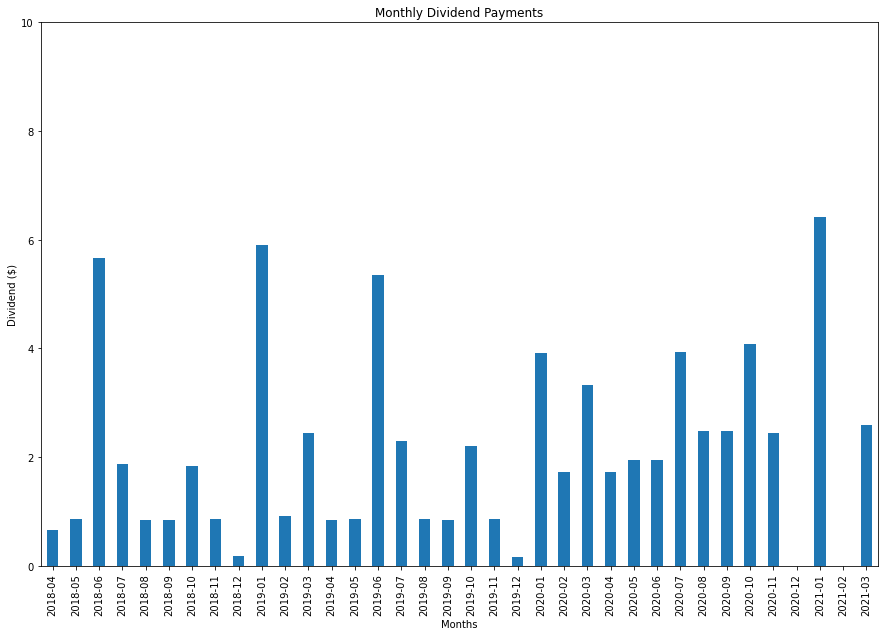

In [15]:
monthly_div_df.plot(kind='bar',
                    title='Monthly Dividend Payments',
                    xlabel='Months',
                    ylabel='Dividend ($)',
                    figsize=(15, 10),
                    legend=False,
                    ylim=(0, 10))

## Portfolio Performance

In [16]:
performance_summary = {
    'Portfolio Return (%)': [],
    'Total Dividend Earned ($)': []
}

performance_summary['Portfolio Return (%)'].append(
    100 * (total_market_value - total_costs) / total_costs)
performance_summary['Total Dividend Earned ($)'].append(total_div_earned)
performance_df = pd.DataFrame(performance_summary)
performance_df

,Portfolio Return (%),Total Dividend Earned ($)
0,0.128989,76.24


In [17]:
def color_negative_red(value):

    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

In [18]:
portfolio = portfolio[[
    'Description', 'Currency', 'Quantities', 'Market Value', '%Portfolio',
    'Gain/Loss (%)'
]]
portfolio = portfolio.style.applymap(color_negative_red, subset=['Gain/Loss (%)'])

In [19]:
portfolio

,Description,Currency,Quantities,Market Value,%Portfolio,Gain/Loss (%)
Symbol,,,,,,
O,REALTY INCOME CORP,USD,75,4762.500000,15.170000,3.760000
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARKET ETF,USD,3,620.070000,1.970000,5.630000
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,638.260000,2.030000,-0.170000
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1119.720000,3.570000,-8.230000
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/01/2013,USD,4,541.800000,1.730000,-10.690000
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND ETF,USD,5,564.650000,1.800000,-4.810000


In [20]:
balance_df

,CAD,USD
Category,,
Cash,31785.3365,23155.1215
Market Value,0.0000,8247.0000
Total Equity,31785.3365,31402.1215
Cash (%),100.0000,73.7400
Equity (%),0.0000,26.2600
